In [3]:
%%capture
!pip install gcpds-cv-pykit
!pip install simpleitk

In [35]:
import os
import re
import cv2
import wandb
import torch
import time
import numpy as np
import torchvision.io
import SimpleITK as sitk
from torch.amp import autocast
import matplotlib.pyplot as plt
from torchvision.io import ImageReadMode
import torchvision.transforms.functional as TF
from typing import Tuple, Optional, Dict, List
from matplotlib.colors import ListedColormap
from gcpds_cv_pykit.datasets import FeetMamitas
from gcpds_cv_pykit.baseline.dataloaders import Segmentation_DataLoader
from gcpds_cv_pykit.visuals import random_sample_visualization
from gcpds_cv_pykit.baseline.models import UNet
from gcpds_cv_pykit.baseline import PerformanceModels

In [5]:
# Set a seed
seed = 42

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [6]:
FeetMamitas()

Using Colab cache for faster access to the 'feet-mamitas' dataset.
Path to downloaded dataset files: /kaggle/input/feet-mamitas
Original dataset folder '/kaggle/input/feet-mamitas' is read-only. Using it directly.


'/kaggle/input/feet-mamitas'

In [7]:
!cp -r /kaggle/input/feet-mamitas /content/datasets/

In [ ]:
config = {"Dir of dataset": "./datasets/feet-mamitas", "Batch size": 36, "Image size": (256,256), "Input size": (3,256,256),
          "Number of classes": 1, "Single class train": None, "Single class test": None, "Single class valid": None, "Images folder": "images",
          "Data augmentation": False, "Device": "cuda:0", "AMixPre": True, "Backbone": "resnet34","Pretrained": True, "Activation function": "sigmoid",
          "Save results": True, "Wandb monitoring": ["WandB_API_Key"]}

In [70]:
train_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Train", config["Single class train"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/feet-mamitas/Train/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 248


Organizing masks: 100%|██████████| 248/248 [00:00<00:00, 204238.64it/s]


In [71]:
valid_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Valid", config["Single class valid"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/feet-mamitas/Valid/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 71


Organizing masks: 100%|██████████| 71/71 [00:00<00:00, 101740.89it/s]


In [72]:
test_dataset = Segmentation_DataLoader(config["Dir of dataset"], config["Batch size"], config["Image size"], config["Number of classes"],
                                        "Test", config["Single class test"], config["Data augmentation"], config["Images folder"])

Searching for images in: datasets/feet-mamitas/Test/images
Supported formats: *.png, *.jpg, *.jpeg
Number of image files found: 35


Organizing masks: 100%|██████████| 35/35 [00:00<00:00, 55064.01it/s]


Images: torch.Size([36, 3, 256, 256]), Masks: torch.Size([36, 1, 256, 256])


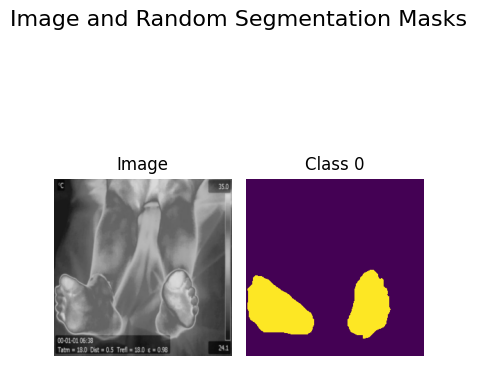

In [73]:
random_sample_visualization(dataset=train_dataset, num_classes=config["Number of classes"],
                            single_class=config['Single class train'],type='baseline')

In [74]:
wandb.login(key=config["Wandb monitoring"][0])
run = wandb.init(project='MasterTests',
    entity='gcpds',
    job_type="upload-artifact")

# UNet model
artifact = run.use_artifact('gcpds/MasterTests/best_model:v58', type='model')
artifact_dir = artifact.download()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


wandb: Downloading large artifact 'best_model:v58', 93.60MB. 1 files...
wandb:   1 of 1 files downloaded.  
Done. 00:00:00.7 (132.6MB/s)


In [ ]:
UNet_model = UNet(in_channels=config["Input size"][0],out_channels=config["Number of classes"], final_activation=config["Activation function"])
state_dict = torch.load('/content/artifacts/best_model:v58/best_model.pt', weights_only=True)
UNet_model.load_state_dict(state_dict)
UNet_model.to(torch.device(config.get('Device', 'cpu')))
UNet_model.eval()

In [75]:
images, masks = next(iter(test_dataset))

images = images.to(torch.device(config.get('Device', 'cpu')))
masks = masks.to(torch.device(config.get('Device', 'cpu')))

In [76]:
with torch.no_grad():
  if config.get("AMixPre", False):
      with autocast(torch.device(config.get('Device', 'cpu')).type):
          UNet_pred = UNet_model(images)
  else:
      UNet_pred = UNet_model(images)

In [77]:
sample = 5
mask = masks[sample].cpu().numpy()[0]
UNet_pred = np.where(UNet_pred[sample].cpu().numpy()[0]>0.5,1,0)

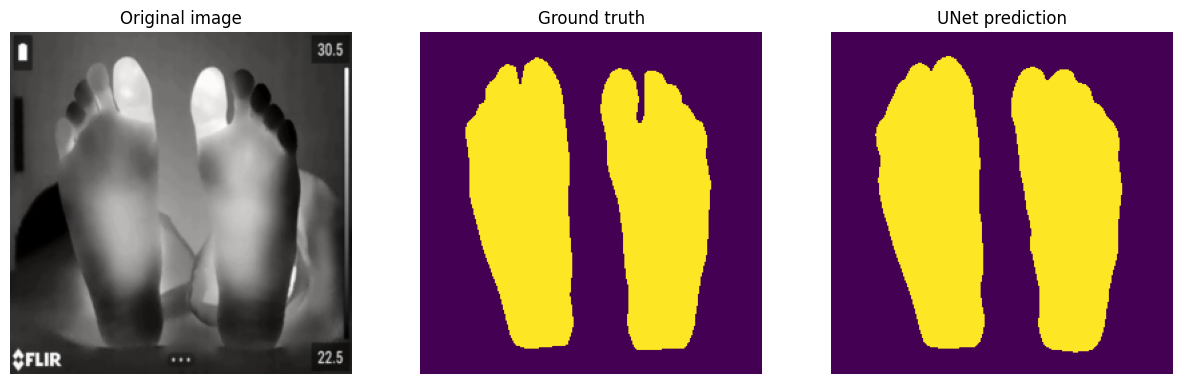

In [78]:
fig, axs = plt.subplots(1, 3, figsize=(15, 7))

axs[0].imshow(images[sample].permute(1, 2, 0).cpu().numpy())
axs[0].set_title('Original image')
axs[0].axis('off')

axs[1].imshow(mask)
axs[1].set_title('Ground truth')
axs[1].axis('off')

axs[2].imshow(UNet_pred)
axs[2].set_title('UNet prediction')
axs[2].axis('off')

plt.show()

In [22]:
artifact = run.use_artifact('gcpds/MasterTests/DermatomesTemplate:v0', type='images')
artifact_dir = artifact.download()

wandb:   1 of 1 files downloaded.  


### Deformable (non-rigid) registration

Deformable registration allows the image to be adjusted *locally*, correcting distortions that cannot be captured by a simple rotation or translation.  
The transformation is defined as

$T(\mathbf{x}) = \mathbf{x} + \sum_{i} \phi_i B_i(\mathbf{x})$

where  
- $\mathbf{x}$ is the original spatial coordinate,  
- $\phi_i$ are the control coefficients (displacement vectors), and  
- $B_i(\mathbf{x})$ are B-spline basis functions that regularize the deformation.

To measure how well the moving image $I_m$ is aligned with the fixed image $I_f$, we use a cost function based on the **negative correlation** between the two images:

$C\!\bigl(I_f,\; I_m \circ T\bigr) = -\mathrm{Corr}\!\bigl(I_f,\; I_m \circ T\bigr)$

with

$-\mathrm{Corr}\!\bigl(I_f,\; I_m \circ T\bigr)
= -\frac{\displaystyle \sum_{\mathbf{x}} \Bigl(I_f(\mathbf{x}) - \overline{I}_f\Bigr)\,\Bigl(I_m\bigl(T(\mathbf{x})\bigr) - \overline{I_m \circ T}\Bigr)}
{\sqrt{\displaystyle \sum_{\mathbf{x}} \Bigl(I_f(\mathbf{x}) - \overline{I}_f\Bigr)^2}\;\sqrt{\displaystyle \sum_{\mathbf{x}} \Bigl(I_m\bigl(T(\mathbf{x})\bigr) - \overline{I_m \circ T}\Bigr)^2}}.$

Minimizing this cost,

$T^* = \arg\min_{T} C\!\bigl(I_f,\; I_m \circ T\bigr),$

maximizes the correlation between the fixed and moving images, yielding the optimal deformable alignment.

In [90]:
class DermatomeRegistration:
    def __init__(self, unet_model, config):
        self.unet_model = unet_model
        self.config = config
        self.registration_callback_data = []

    def _plot_predict(self, y, y_pred):
        """
        Generates an image highlighting true positives, false positives, and false negatives.
        """
        red = np.logical_and(~y, y_pred)[..., None]  # false positive
        green = np.logical_and(y, y_pred)[..., None]  # true positive
        blue = np.logical_and(y, ~y_pred)[..., None]  # false negative
        image = np.concatenate((red, green, blue), axis=2).astype('float')
        return image

    def _define_contour(self, dermatomes):
        """
        Defines contours for each dermatome region.
        """
        without_contours = dermatomes.copy()
        uniques = sorted(np.unique(without_contours))[1:]
        for unique in uniques:
            binary_img = (without_contours == unique).astype('uint8')
            contours, _ = cv2.findContours(binary_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            dermatomes = cv2.drawContours(dermatomes, contours, -1, 255, 1)
        return dermatomes

    def _registration_callback(self, method):
        """
        Callback function to record registration progress.
        """
        self.registration_callback_data.append(method.GetMetricValue())

    def _non_rigid_registration(self, fixed_image, moving_image):
        """
        Performs non-rigid registration using SimpleITK.
        """
        fixed_image_sitk = sitk.Cast(sitk.GetImageFromArray(fixed_image.copy()), sitk.sitkFloat32)
        moving_image_sitk = sitk.Cast(sitk.GetImageFromArray(moving_image.copy()), sitk.sitkFloat32)

        transform_domain_mesh_size = [3] * fixed_image_sitk.GetDimension()
        tx = sitk.BSplineTransformInitializer(fixed_image_sitk, transform_domain_mesh_size)

        R = sitk.ImageRegistrationMethod()
        R.SetMetricAsCorrelation()
        R.SetOptimizerAsGradientDescentLineSearch(learningRate=10.,
                                                   numberOfIterations=600,
                                                   convergenceMinimumValue=1e-20,
                                                   convergenceWindowSize=30)
        R.SetMetricSamplingStrategy(R.REGULAR)
        R.SetMetricSamplingPercentage(0.2, seed=42)
        R.SetInterpolator(sitk.sitkNearestNeighbor)
        R.SetInitialTransformAsBSpline(tx, inPlace=False, scaleFactors=[1, 2, 4, 8])

        self.registration_callback_data = []  # Clear previous data
        R.AddCommand(sitk.sitkIterationEvent, lambda: self._registration_callback(R))

        out_tx = R.Execute(fixed_image_sitk, moving_image_sitk)
        return out_tx

    def _resample(self, moving_image, fixed_image, registration_transform):
        """
        Resamples the moving image to the fixed image's space using the given transform.
        """
        fixed_image_sitk = sitk.Cast(sitk.GetImageFromArray(fixed_image), sitk.sitkFloat32)
        moving_image_sitk = sitk.Cast(sitk.GetImageFromArray(moving_image), sitk.sitkFloat32)
        return sitk.GetArrayFromImage(sitk.Resample(moving_image_sitk, fixed_image_sitk, registration_transform, sitk.sitkNearestNeighbor))

    def _register_one_foot(self, foot, dermatomes):
        """
        Registers dermatomes to a single foot image.
        """
        height, width = foot.shape[:2]
        dermatomes_resized = cv2.resize(dermatomes, (width, height), interpolation=cv2.INTER_NEAREST)
        mask_dermatomes = (dermatomes_resized.copy() > 0).astype('float')
        registration_transform = self._non_rigid_registration(foot, mask_dermatomes)
        registered = self._resample(dermatomes_resized, foot, registration_transform)
        return registered

    def _extract_feet(self, img):
        """
        Extracts individual foot regions from a segmented image.
        """
        img = img.astype('uint8')
        contours, _ = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        if len(contours) == 0:
            return None, None, []

        contours = list(contours)
        contours.sort(reverse=True, key=lambda c: cv2.contourArea(c))

        coords = []
        for c in contours[:2]:
            y_bottom = c[c[:, :, 1].argmax()][0][1]
            x_right = c[c[:, :, 0].argmin()][0][0]
            y_top = c[c[:, :, 1].argmin()][0][1]
            x_left = c[c[:, :, 0].argmax()][0][0]
            coords.append([y_top, y_bottom, x_right, x_left, c])

        if len(coords) == 1:
            # Right foot
            right_foot = np.zeros_like(img)
            right_foot = cv2.drawContours(right_foot, [coords[0][-1]], -1, 1, -1)
            right_foot = right_foot[coords[0][0]:coords[0][1], coords[0][2]:coords[0][3]]
            return right_foot, None, coords

        coords.sort(key=lambda x: x[2])
        right_foot = np.zeros_like(img)
        right_foot = cv2.drawContours(right_foot, [coords[0][-1]], -1, 1, -1)
        right_foot = right_foot[coords[0][0]:coords[0][1], coords[0][2]:coords[0][3]]

        left_foot = np.zeros_like(img)
        left_foot = cv2.drawContours(left_foot, [coords[1][-1]], -1, 1, -1)
        left_foot = left_foot[coords[1][0]:coords[1][1], coords[1][2]:coords[1][3]]

        return right_foot, left_foot, coords

    def _get_dermatomes(self, fixed_mask, path_right_foot_template, path_left_foot_template):
        """
        Registers dermatome templates to the extracted foot masks.
        """
        fixed_mask = np.squeeze(fixed_mask)
        right_dermatomes_template = cv2.flip(cv2.imread(path_right_foot_template, cv2.IMREAD_GRAYSCALE), 1)
        left_dermatomes_template = cv2.imread(path_left_foot_template, cv2.IMREAD_GRAYSCALE)
        left_dermatomes_template[left_dermatomes_template != 0] = left_dermatomes_template[left_dermatomes_template != 0] + 1

        right_foot, left_foot, coords = self._extract_feet(fixed_mask)

        output_dermatomes = np.zeros_like(fixed_mask, dtype='float')

        if right_foot is not None:
            right_dermatomes_registered = self._register_one_foot(right_foot, right_dermatomes_template)
            output_dermatomes[coords[0][0]:coords[0][1], coords[0][2]:coords[0][3]] = right_dermatomes_registered

        if left_foot is not None and len(coords) >= 2:
            left_dermatomes_registered = self._register_one_foot(left_foot, left_dermatomes_template)
            output_dermatomes[coords[1][0]:coords[1][1], coords[1][2]:coords[1][3]] += left_dermatomes_registered

        output_dermatomes = self._define_contour(output_dermatomes)
        return output_dermatomes

    def _overlay_dermatomes_on_image(self, original_image, dermatomes):
        """
        Overlays dermatome contours on the original image.
        """
        gray = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
        out_img = cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR)

        unique_labels = np.unique(dermatomes)
        for label in unique_labels:
            if label == 0:
                continue
            mask = (dermatomes == label).astype('uint8')
            contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(out_img, contours, -1, (0, 0, 255), 2)

        return out_img

    def _compute_dermatome_temperatures(self, original_temp, dermatomes):
        """
        Computes the mean temperature for each dermatome region.
        """
        results = {}
        unique_labels = np.unique(dermatomes)
        valid_labels = [label for label in unique_labels if label != 0 and label != 255]

        dermatome_names = {
            10: 'Right Foot Medial Plantar',
            11: 'Left Foot Medial Plantar',
            20: 'Right Foot Lateral Plantar',
            21: 'Left Foot Lateral Plantar',
            30: 'Right Foot Sural',
            31: 'Left Foot Sural',
            40: 'Right Foot Tibial',
            41: 'Left Foot Tibial',
            50: 'Right Foot Saphenous',
            51: 'Left Foot Saphenous'
        }

        for label in valid_labels:
            region_mask = (dermatomes == label)
            if np.sum(region_mask) > 0:
                mean_temp = original_temp[region_mask].mean()
                name = dermatome_names.get(label, f"Dermatome {label}")
                results[name] = mean_temp

        return results

    def process_image_with_registration(self, img_path, path_right_foot_template, path_left_foot_template):
        """
        Main method to process an image, perform registration, and compute dermatome temperatures.
        """
        img_tensor = torchvision.io.read_image(str(img_path), mode=ImageReadMode.RGB)
        H, W = self.config.get("Image size", (256, 256))
        img_tensor = TF.resize(img_tensor, (H, W))
        if img_tensor.float().max() > 1.0:
            img_tensor = img_tensor.float() / 255.0
        else:
            img_tensor = img_tensor.float()
        img_tensor = img_tensor.unsqueeze(0).to(torch.device(self.config.get('Device', 'cpu')))

        with torch.no_grad():
            if self.config.get("AMixPre", False):
                with autocast(torch.device(self.config.get('Device', 'cpu')).type):
                    unet_pred = self.unet_model(img_tensor)
            else:
                unet_pred = self.unet_model(img_tensor)
        mask_combined = np.where(unet_pred[0].cpu().numpy()[0] > 0.5, 1, 0).astype(np.uint8)

        t0 = time.time()
        dermatomes = self._get_dermatomes(mask_combined, path_right_foot_template, path_left_foot_template)
        t1 = time.time() - t0
        print(f"[{os.path.basename(img_path)}] Registration time: {t1:.4f} s")

        img_numpy = img_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
        img_float = img_numpy.astype(np.float32) / 255.0
        range_ = [22.5, 30.5]
        original_temp = img_float * (range_[1] - range_[0]) + range_[0]

        temp_results = self._compute_dermatome_temperatures(original_temp, dermatomes)

        return {
            "img": img_numpy,
            "mask_combined": mask_combined,
            "dermatomes": dermatomes,
            "original_temp": original_temp,
            "temp_results": temp_results,
            "registration_convergence_data": self.registration_callback_data
        }

    def plot_results(self, data):
        """
        Plots the original thermographic image, YOLO mask, and registered dermatomes.
        """
        if data is None:
            print("No data to plot.")
            return

        img = data["img"]
        mask_combined = data["mask_combined"]
        dermatomes = data["dermatomes"]
        overlay_img = self._overlay_dermatomes_on_image(img, dermatomes)

        fig, axs = plt.subplots(1,4, figsize=(15, 10))
        axs[0].imshow(img[..., ::-1])
        axs[0].set_title("Thermographic Image")

        axs[1].imshow(mask_combined, cmap='gray')
        axs[1].set_title("UNet's segmentation")

        axs[2].imshow(overlay_img[..., ::-1])
        axs[2].set_title("Dermatome Contours")

        axs[3].imshow(dermatomes, cmap='jet')
        axs[3].set_title("Registered Dermatomes")

        for ax in axs.flat:
            ax.set_axis_off()

        plt.tight_layout()
        plt.show()

    def plot_registration_convergence(self, data):
        """
        Plots the convergence of the non-rigid registration metric.
        """
        if data is None or "registration_convergence_data" not in data or not data["registration_convergence_data"]:
            print("No registration convergence data to plot.")
            return

        convergence_data = data["registration_convergence_data"]
        iterations = range(len(convergence_data))

        plt.figure(figsize=(10, 6))
        plt.plot(iterations, convergence_data, marker='o', linestyle='-')
        plt.title("Non-Rigid Registration Convergence")
        plt.xlabel("Iteration")
        plt.ylabel("Metric Value (Correlation)")
        plt.grid(True)
        plt.show()

In [91]:
dermatome_processor = DermatomeRegistration(unet_model=UNet_model, config=config)

In [92]:
results = dermatome_processor.process_image_with_registration(
    img_path='/content/datasets/feet-mamitas/Test/images/sample_5.png',
    path_right_foot_template='/content/artifacts/DermatomesTemplate:v0/Dermatomes template.png',
    path_left_foot_template='/content/artifacts/DermatomesTemplate:v0/Dermatomes template.png'
)

[sample_5.png] Registration time: 5.1733 s


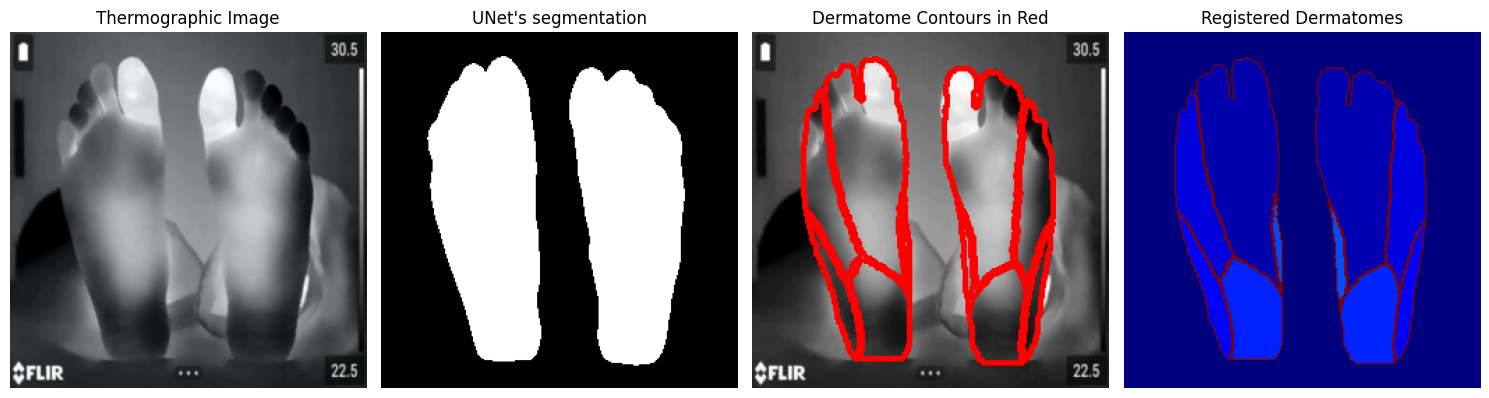

In [95]:
# Plot the main results (thermographic image, YOLO mask, registered dermatomes)
dermatome_processor.plot_results(results)

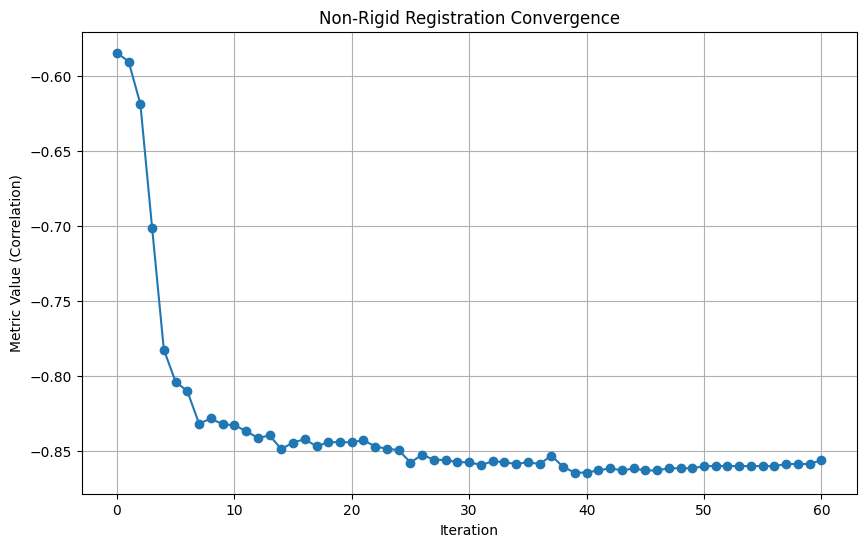

In [94]:
# Plot the registration convergence
dermatome_processor.plot_registration_convergence(results)

### **Organización del dataset en carpetas por caso**

In [ ]:
# Directorios de origen (ajusta según tu estructura)
base_dir = "./datasets/MAMITAS-YOLO-3"
train_dir = os.path.join(base_dir, "train/images")
valid_dir = os.path.join(base_dir, "valid/images")
test_dir  = os.path.join(base_dir, "test/images")

# Directorio donde se crearán las carpetas por caso
cases_dir = "./cases"
if not os.path.exists(cases_dir):
    os.makedirs(cases_dir)

# Patrón regex para identificar las imágenes originales en train.
original_pattern = re.compile(r"^t\d+_caso\d+_jpg\.rf\.[A-Za-z0-9]+\.jpg$", re.IGNORECASE)

def extract_time_case(filename):
    m = re.search(r"t(\d+)_caso(\d+)_", filename, re.IGNORECASE)
    if m:
        time_val = int(m.group(1))
        case_num = int(m.group(2))
        return time_val, case_num
    return None, None

def copy_images_to_cases(source_dir, filter_original=False):
    """
    Copia las imágenes del directorio source_dir a las carpetas de caso en ./cases.
    Si filter_original es True (para train) se usará para asignar una puntuación alta
    a las imágenes originales (sin rotación ni ruido).
    Además, se verifica que para cada caso y tiempo (tX) solo se copie la imagen con
    mayor puntuación.
    """
    # Diccionario para agrupar por (caso, tiempo): valor = (score, filename)
    best_files = {}  # key: (case_num, time_val), value: (score, filename)

    for file in os.listdir(source_dir):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            t_val, case_num = extract_time_case(file)
            if case_num is None or t_val is None:
                continue
            # Asignar score: 1 si coincide con el patrón original, 0 de lo contrario.
            score = 1 if original_pattern.match(file) else 0
            key = (case_num, t_val)
            # Si ya existe un archivo para ese (caso, tiempo), se reemplaza solo si el score es mayor.
            if key in best_files:
                if score > best_files[key][0]:
                    best_files[key] = (score, file)
            else:
                best_files[key] = (score, file)

    # Copiar las imágenes seleccionadas a la carpeta correspondiente.
    for (case_num, time_val), (_, file) in best_files.items():
        case_folder = os.path.join(cases_dir, f"Case{case_num}")
        if not os.path.exists(case_folder):
            os.makedirs(case_folder)
        src = os.path.join(source_dir, file)
        dst = os.path.join(case_folder, file)
        shutil.copy(src, dst)

# Copiar imágenes de valid y test (se asume que son originales y no hay duplicados)
copy_images_to_cases(valid_dir, filter_original=False)
copy_images_to_cases(test_dir, filter_original=False)
# Para train, copiar solo las imágenes originales (o la de mayor score entre duplicados)
copy_images_to_cases(train_dir, filter_original=True)

print("Imágenes copiadas a las carpetas por caso.")


Imágenes copiadas a las carpetas por caso.


In [ ]:
case_numbers = set()
for source_dir in [train_dir, valid_dir, test_dir]:
    for file in os.listdir(source_dir):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            _, case_num = extract_time_case(file)
            if case_num is not None:
                case_numbers.add(case_num)
print("Casos encontrados:", sorted(list(case_numbers)))

Casos encontrados: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]


[t0_Caso1_jpg.rf.07affa13b78162cf4550612974517143.jpg] Tiempo de registro: 13.1941 s
[t1_Caso1_jpg.rf.8893ace9b8a23a379eceaf1dcbafe69c.jpg] Tiempo de registro: 16.2123 s
[t5_Caso1_jpg.rf.de554e84d44302b2844799c019ad89c5.jpg] Tiempo de registro: 8.5607 s
[t10_Caso1_jpg.rf.78c7e4d20aa4bf738beeb63abf2fa02e.jpg] Tiempo de registro: 19.6287 s
[t15_Caso1_jpg.rf.beef2fa318b9eb592ea1d7901e237e2c.jpg] Tiempo de registro: 7.2415 s
[t20_Caso1_jpg.rf.8f6b9f33a47e38fc4ed8edfa21d6f0c0.jpg] Tiempo de registro: 11.9802 s


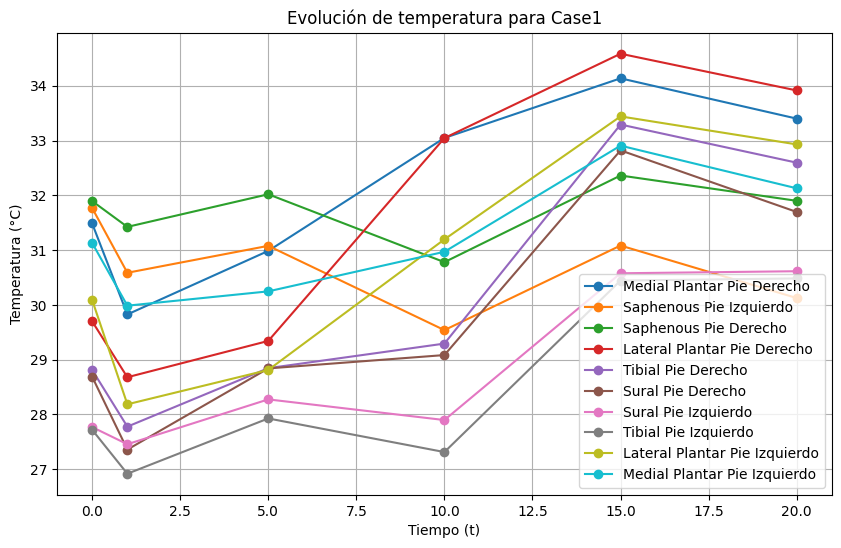

[t0_Caso2_jpg.rf.7b025aab78d53a7db588742e7b1624d3.jpg] Tiempo de registro: 8.9668 s
[t1_Caso2_jpg.rf.e4c42ab323d6ebd1db3dcef10b1e9d04.jpg] Tiempo de registro: 12.2914 s
[t5_Caso2_jpg.rf.e58fdf5d1031504425f45da7d692e6ea.jpg] Tiempo de registro: 11.9833 s
[t10_Caso2_jpg.rf.5a177591eba8b19fe7955f988dcb9787.jpg] Tiempo de registro: 15.0829 s
[t15_Caso2_jpg.rf.94b16fdcd8b970cde5e619c09908c3be.jpg] Tiempo de registro: 13.3431 s
[t20_Caso2_jpg.rf.7ebc541a83860997c954dd66c19beaa6.jpg] Tiempo de registro: 7.8880 s
[t25_Caso2_jpg.rf.7540269c986b9c1f9f24f87bed3b4dc8.jpg] Tiempo de registro: 9.2611 s


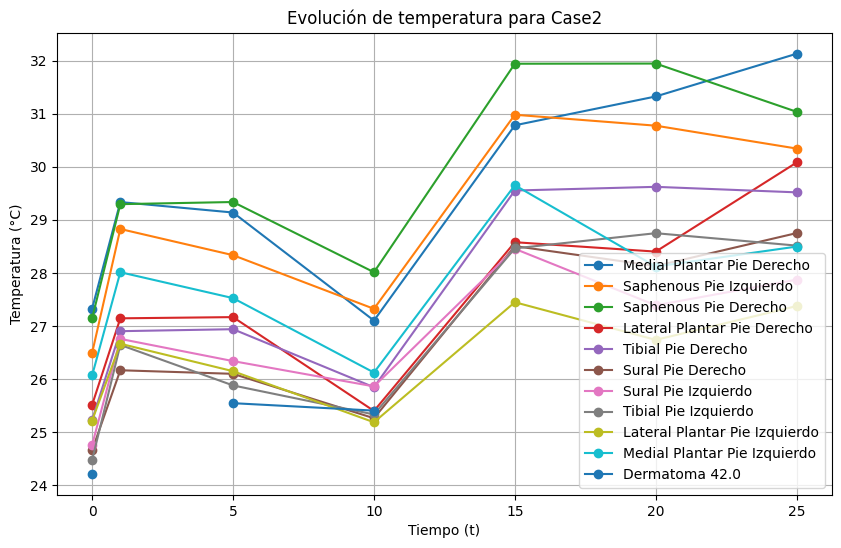

[t0_Caso3_jpg.rf.42fe8287f47bebe7eee89048e09d67cc.jpg] Tiempo de registro: 29.7562 s
[t1_Caso3_jpg.rf.6ca875efdc501859fda6d91a9cc6e6a9.jpg] Tiempo de registro: 14.8618 s
[t5_Caso3_jpg.rf.3383736cc867e8e40d27440560475c8b.jpg] Tiempo de registro: 16.2184 s
[t10_Caso3_jpg.rf.f8277f7035827959e9eed0cb381efbcf.jpg] Tiempo de registro: 9.5938 s
[t15_Caso3_jpg.rf.8a11b68c05f10442f56a3a1a46ce010e.jpg] Tiempo de registro: 10.8402 s
[t20_Caso3_jpg.rf.eca48fc7af77ede60b3727b32f684638.jpg] Tiempo de registro: 11.6994 s


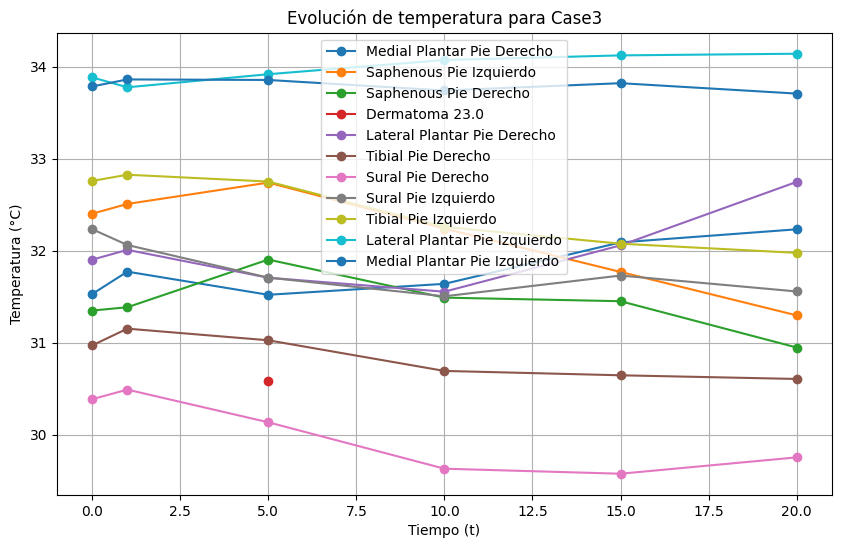

[t0_Caso4_jpg.rf.210021b01f583109e8f1f8b0526dd6e4.jpg] Tiempo de registro: 7.5369 s
[t1_Caso4_jpg.rf.57b626ca1824870f919db0516e94314f.jpg] Tiempo de registro: 10.2419 s
[t5_Caso4_jpg.rf.45eaf907e89e879256c6fc107a49caf1.jpg] Tiempo de registro: 6.2934 s
[t10_Caso4_jpg.rf.ff5c44501b98181b79b47f4347dc42fa.jpg] Tiempo de registro: 6.9448 s
[t15_Caso4_jpg.rf.750e3f4f8601583662cda5fe9619948a.jpg] Tiempo de registro: 8.6263 s
[t20_Caso4_jpg.rf.a56879d97b4931552b2dd94ee86b0475.jpg] Tiempo de registro: 11.4764 s


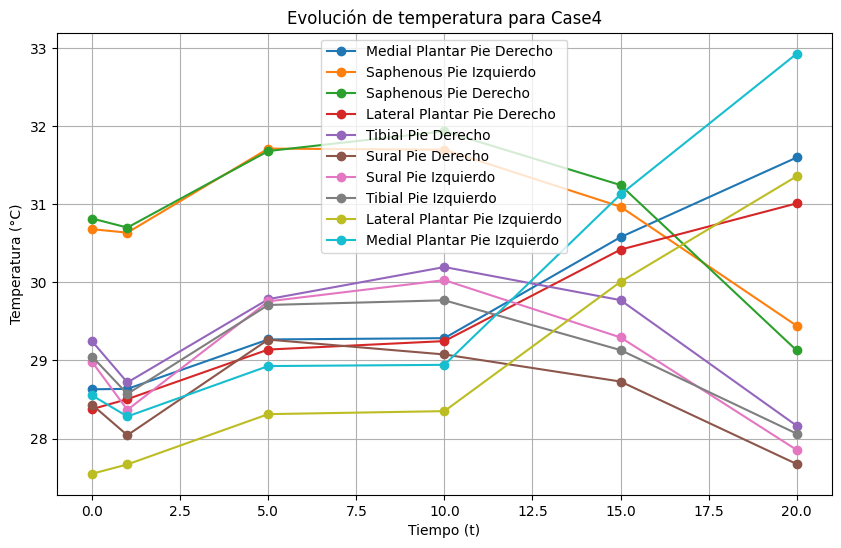

[t0_Caso5_jpg.rf.a317586b2d7262fd5ced77f85fefc4e8.jpg] Tiempo de registro: 10.3435 s
[t1_Caso5_jpg.rf.4ad06ba1426ca46ec373429ec16ca7cb.jpg] Tiempo de registro: 8.3214 s
[t5_Caso5_jpg.rf.aee6203d255c0b2f80f951c3e6b96d76.jpg] Tiempo de registro: 11.9115 s
[t10_Caso5_jpg.rf.c2625623afc3f25ff771b1d7cd339d34.jpg] Tiempo de registro: 11.2339 s
[t15_Caso5_jpg.rf.58ca0a4ff8b4a4f4db9b75dd2c84ba48.jpg] Tiempo de registro: 13.3623 s
[t20_Caso5_jpg.rf.0492cee193d968a2d8b605caa56e978f.jpg] Tiempo de registro: 12.9004 s


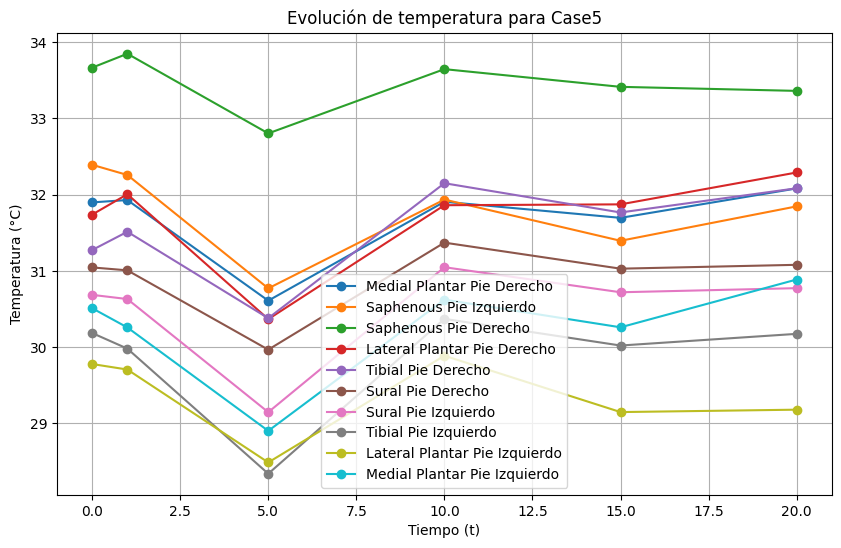

[t0_Caso6_jpg.rf.16851280e222dbdadc3c49c9fc0a9759.jpg] Tiempo de registro: 7.5440 s
[t1_Caso6_jpg.rf.cdea88ec77940ee8722237aaee1ba704.jpg] Tiempo de registro: 8.9663 s
[t5_Caso6_jpg.rf.ad7957b8ea3ba54e007819dc079ea7a1.jpg] Tiempo de registro: 11.4509 s
[t10_Caso6_jpg.rf.c15e9349aca45de79b0d7c3bce39efe0.jpg] Tiempo de registro: 10.9180 s
[t15_Caso6_jpg.rf.a9f0a8c96ee2386588e45e6fdf68829b.jpg] Tiempo de registro: 17.7627 s
[t20_Caso6_jpg.rf.3761c75c972134b8f3e0b803e70beee9.jpg] Tiempo de registro: 11.8237 s


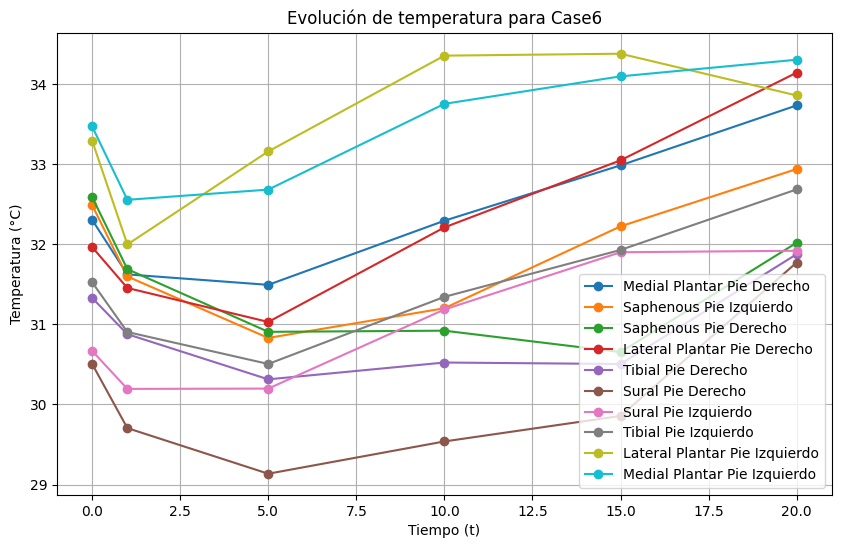

[t0_Caso7_jpg.rf.093a7cb9a6a9511867c0760ff712e9b9.jpg] Tiempo de registro: 9.0559 s
[t1_Caso7_jpg.rf.ef66760ef44c1afd242b1ada14b14779.jpg] Tiempo de registro: 13.3354 s
[t5_Caso7_jpg.rf.440addbf852bc02464ccade96c4c56b6.jpg] Tiempo de registro: 7.9837 s
[t10_Caso7_jpg.rf.895d98b3570cdb56b0142833402cf234.jpg] Tiempo de registro: 11.8029 s
[t15_Caso7_jpg.rf.deae508900ec87a964ae7a0745f0651e.jpg] Tiempo de registro: 20.8772 s
[t20_Caso7_jpg.rf.57f284801d53af008fc24917412bca45.jpg] Tiempo de registro: 16.3461 s


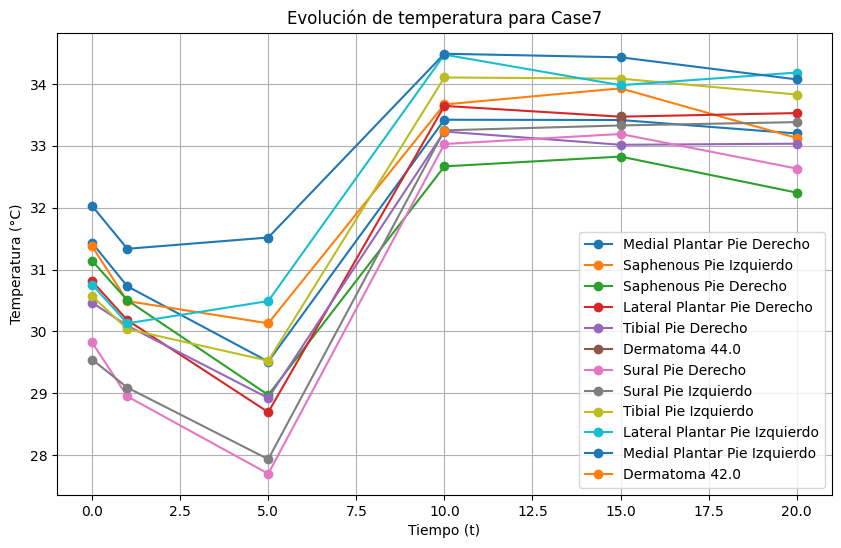

[t0_Caso8_jpg.rf.8f0fa49798cca08553693a4bea0eee4c.jpg] Tiempo de registro: 11.9366 s
[t1_Caso8_jpg.rf.028e6d7fa056052cc09ce77d11f62f5b.jpg] Tiempo de registro: 5.0497 s
[t5_Caso8_jpg.rf.b4eebe251d625da5a4139fac01e52519.jpg] Tiempo de registro: 8.2606 s
[t10_Caso8_jpg.rf.903045933af0be47cb28bc63d7853f8d.jpg] Tiempo de registro: 10.3903 s
[t15_Caso8_jpg.rf.c13b6c3c374122070460e288256b56fa.jpg] Tiempo de registro: 10.2770 s
[t20_Caso8_jpg.rf.ad411ee1138aef3372400558845eba52.jpg] Tiempo de registro: 8.0340 s
[t25_Caso8_jpg.rf.a5c8350e93897eb25772e469de5e74aa.jpg] Tiempo de registro: 12.4169 s


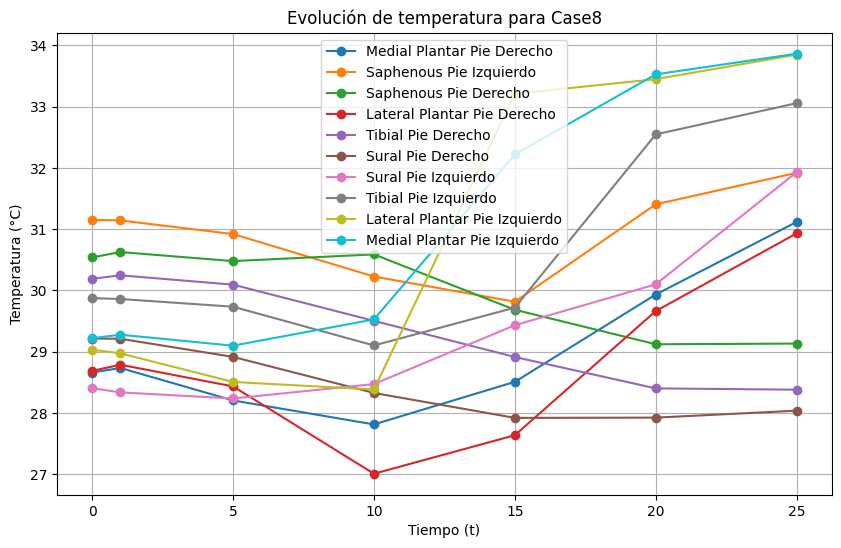

[t0_Caso9_jpg.rf.dc9c529591a7ca3d271a8afa6e3dc6e7.jpg] Tiempo de registro: 3.8625 s
[t1_Caso9_jpg.rf.860e0907ea96b89baf0182c0ce9b102b.jpg] Tiempo de registro: 5.5851 s
[t5_Caso9_jpg.rf.1ce4cb96095731e641601802e569208f.jpg] Tiempo de registro: 9.8146 s
[t10_Caso9_jpg.rf.d904fad936213f7088c58ab787aa7d82.jpg] Tiempo de registro: 5.3081 s
[t15_Caso9_jpg.rf.4cae39ebd30bae0b633075ea1763de04.jpg] Tiempo de registro: 7.6368 s
[t20_Caso9_jpg.rf.15bf00c173ae6166712cde920c367792.jpg] Tiempo de registro: 4.4019 s


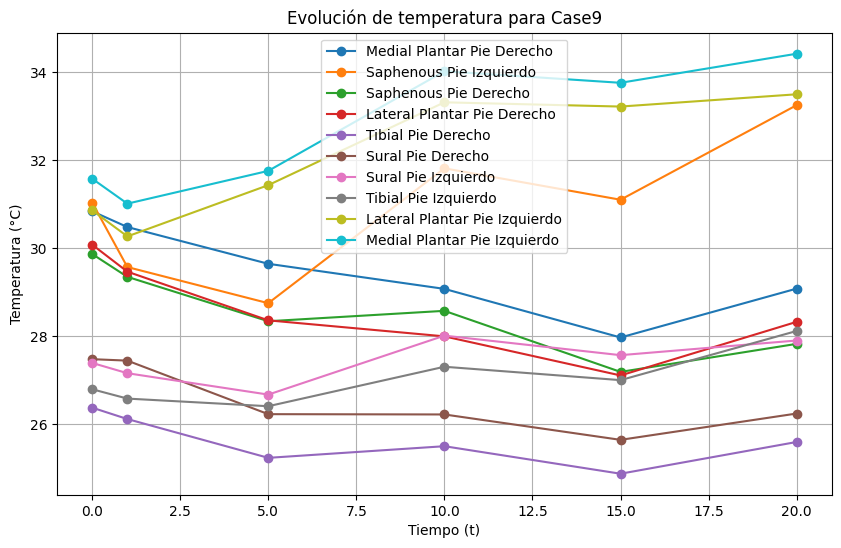

[t0_Caso10_jpg.rf.3830affc21b488fc85389fe4457963a7.jpg] Tiempo de registro: 5.0975 s
[t1_Caso10_jpg.rf.f57a3cedcc21e35b4fa0a81ed162591c.jpg] Tiempo de registro: 4.7021 s
[t5_Caso10_jpg.rf.e0f80f80b6a3eef56bc7d2d3cf30cf14.jpg] Tiempo de registro: 9.0962 s
[t10_Caso10_jpg.rf.8e2ad26a664c467ea0e8bf50ba37ec9d.jpg] Tiempo de registro: 5.7555 s
[t15_Caso10_jpg.rf.d17ffd6bd1f689218adc6655ed6e3b4c.jpg] Tiempo de registro: 5.6459 s
[t20_Caso10_jpg.rf.129cc2324f0b5fb4e44e1647b583d65b.jpg] Tiempo de registro: 7.5818 s


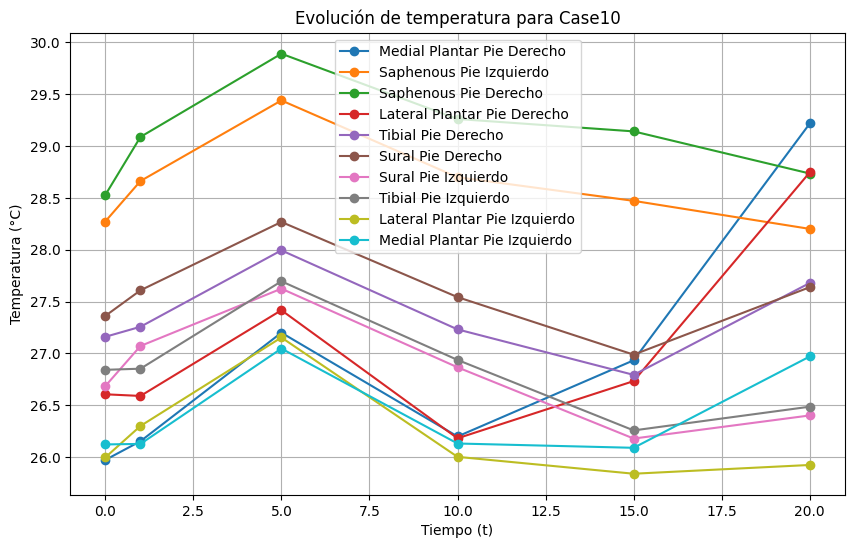

[t0_Caso11_jpg.rf.66db4c33d78a7778bc94c8a698fffb21.jpg] Tiempo de registro: 9.3145 s
[t1_Caso11_jpg.rf.ed62f9dbe619c497b11e956fae8957e5.jpg] Tiempo de registro: 6.5511 s
[t5_Caso11_jpg.rf.725094d1b4fab7311e2749d59e6c69d4.jpg] Tiempo de registro: 6.4200 s
[t10_Caso11_jpg.rf.787377551f27cd62894f6151826f4d9c.jpg] Tiempo de registro: 6.1425 s
[t15_Caso11_jpg.rf.82dfb849de417af1aca410cebc59f11a.jpg] Tiempo de registro: 10.1738 s
[t20_Caso11_jpg.rf.8db5011851a317eef8bfeff8e0020e5a.jpg] Tiempo de registro: 3.8652 s
[t25_Caso11_jpg.rf.78d1e409746718cd47331d7e5fc58dea.jpg] Tiempo de registro: 4.8865 s


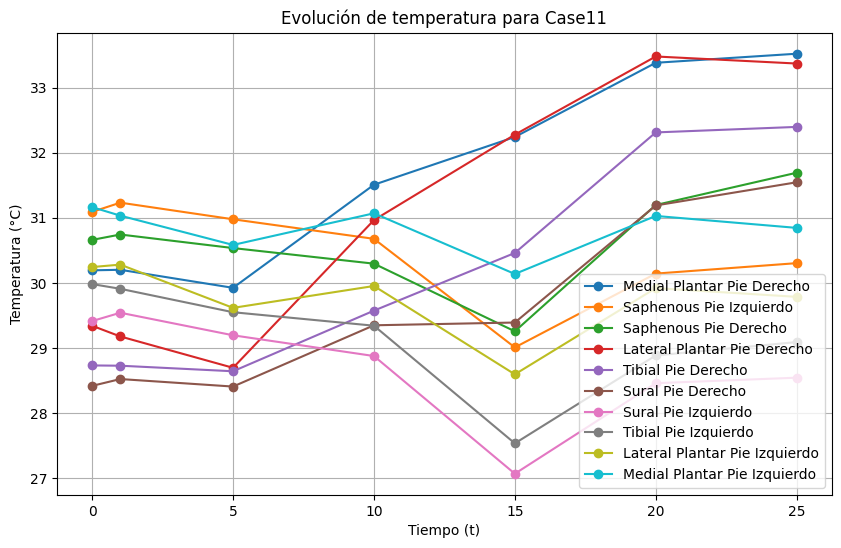

[t0_Caso12_jpg.rf.f6ff1349683866b7e3f8ed439231a392.jpg] Tiempo de registro: 8.2688 s
[t1_Caso12_jpg.rf.c86fdac3be41f8c5912b98342b8ca9c6.jpg] Tiempo de registro: 7.8559 s
[t5_Caso12_jpg.rf.b2e2b99d451f5cbf00c8d739c4c35628.jpg] Tiempo de registro: 9.9901 s
[t10_Caso12_jpg.rf.e7396b37542477ea6a76ae2702cfb535.jpg] Tiempo de registro: 5.8874 s
[t15_Caso12_jpg.rf.5b970225b58c009526f9837cac0fd628.jpg] Tiempo de registro: 7.3636 s
[t20_Caso12_jpg.rf.e2f09bac0b7761a94f864cb62065f421.jpg] Tiempo de registro: 4.5112 s


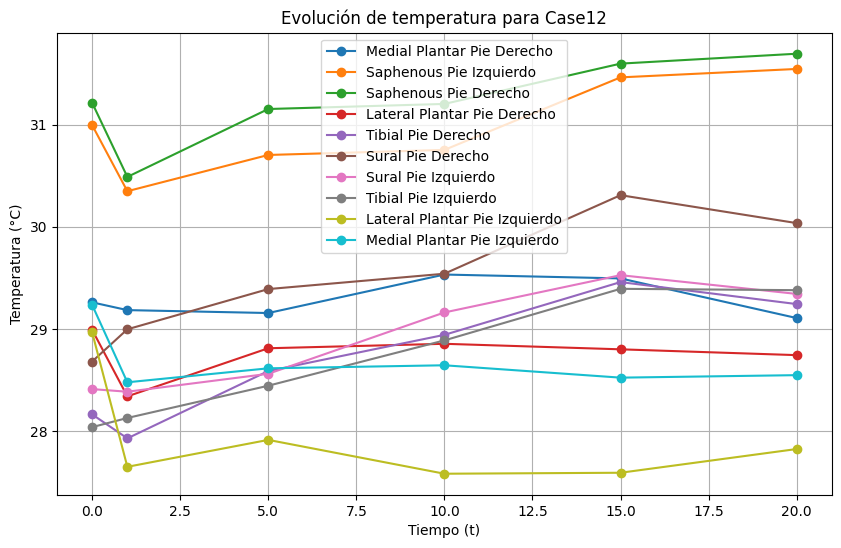

[t0_Caso13_jpg.rf.360e6bf293a5a0692120347bfd56e591.jpg] Tiempo de registro: 8.3307 s
[t1_Caso13_jpg.rf.f7556ecf536ad654d5938f62cea5c3e9.jpg] Tiempo de registro: 8.0016 s
[t5_Caso13_jpg.rf.2bb37269be0423859219316dbede180a.jpg] Tiempo de registro: 8.8145 s
[t10_Caso13_jpg.rf.8f6eefa85e85f42ed50e79b19bb717d4.jpg] Tiempo de registro: 5.2506 s
[t15_Caso13_jpg.rf.a4a1dc3c4023e9b088abe24ab56f1ba5.jpg] Tiempo de registro: 7.5175 s
[t20_Caso13_jpg.rf.b9d562f474ee35c0788ac67d448f03ed.jpg] Tiempo de registro: 10.0238 s
[t25_Caso13_jpg.rf.7bd893709464bac065d70b432e4673c5.jpg] Tiempo de registro: 6.8479 s


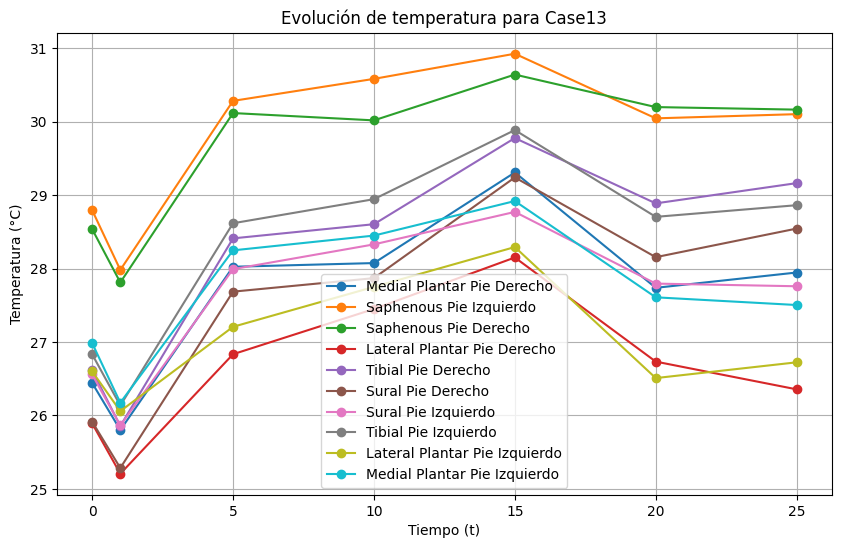

[t0_Caso14_jpg.rf.fb93e7497ff0850a6c6fdaac23edce18.jpg] Tiempo de registro: 5.6635 s
[t1_Caso14_jpg.rf.3f57e7c1056ad21e8b3cc568ccb32cf8.jpg] Tiempo de registro: 18.0684 s
[t5_Caso14_jpg.rf.3615dc667a2c451f9008793c013fa27f.jpg] Tiempo de registro: 9.9767 s
[t10_Caso14_jpg.rf.2466b102788fb7fb95a915f0bfd1dac8.jpg] Tiempo de registro: 12.4922 s
[t15_Caso14_jpg.rf.b4354042664091e53bb57debe3900d19.jpg] Tiempo de registro: 5.2236 s
[t20_Caso14_jpg.rf.e4f131a854df52008f904555cf37b264.jpg] Tiempo de registro: 9.4223 s
[t25_Caso14_jpg.rf.3c7e7d25abe2e247f91edd07ae038488.jpg] Tiempo de registro: 8.8495 s


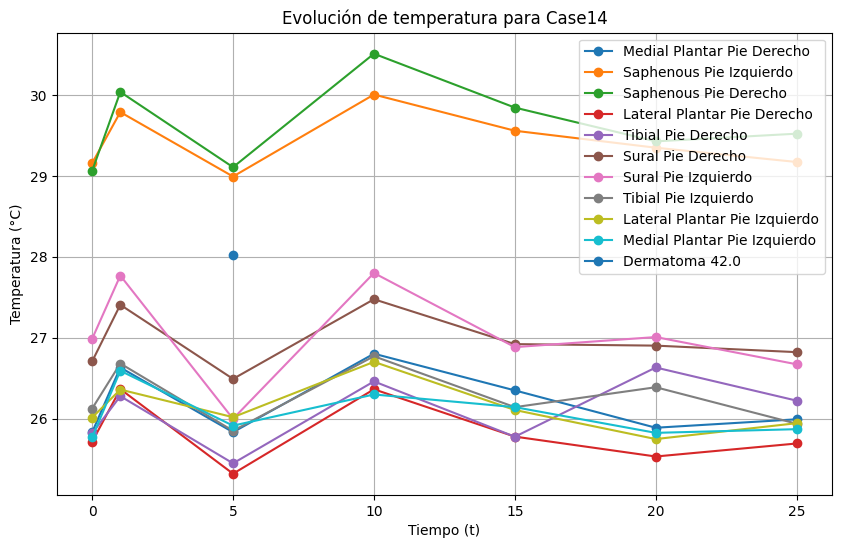

[t0_caso15_jpg.rf.fbf0dca1e3b981f14a34675514c193b4.jpg] Tiempo de registro: 6.5148 s
[t1_caso15_jpg.rf.3e798f216c7d7f2fa8e3cb52e80fab64.jpg] Tiempo de registro: 7.1674 s
[t5_caso15_jpg.rf.4d94b6546fc232b9dbc37910a27509bb.jpg] Tiempo de registro: 3.3627 s
[t10_caso15_jpg.rf.5e170d05087ec363ac7007bb46282049.jpg] Tiempo de registro: 4.9635 s
[t15_caso15_jpg.rf.c863720470c5f812ac28b6e54d644ff1.jpg] Tiempo de registro: 5.1023 s
[t20_caso15_jpg.rf.0006601de1209a83c846f58285b18d7f.jpg] Tiempo de registro: 7.3655 s


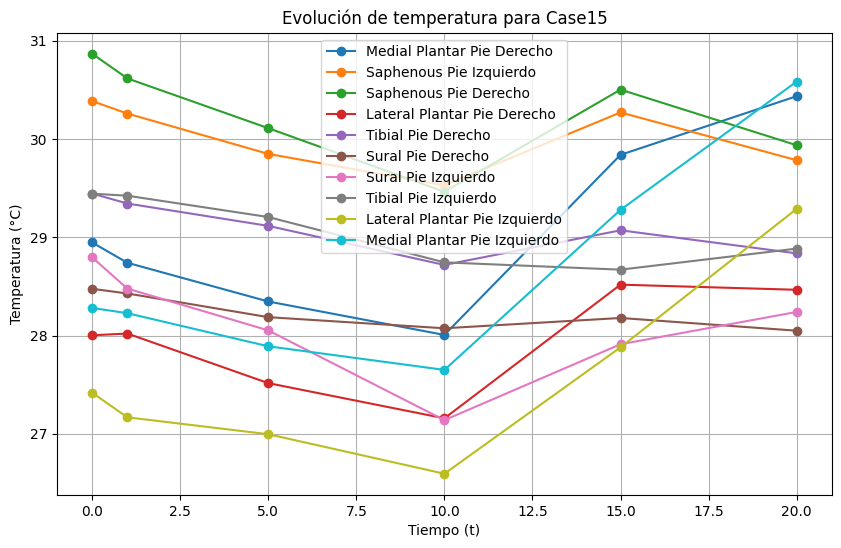

[t0_caso16_jpg.rf.d195e993697755b51f0c26c89a6a6d60.jpg] Tiempo de registro: 4.4910 s
[t1_caso16_jpg.rf.70b4869acde51a5ef078a3b9a0e0ae37.jpg] Tiempo de registro: 4.9613 s
[t5_caso16_jpg.rf.51b116eda30b68cd25c3a755276b2031.jpg] Tiempo de registro: 4.6320 s
[t10_caso16_jpg.rf.d955471e1b95e622fddc9b02ebe79abe.jpg] Tiempo de registro: 7.5398 s
[t15_caso16_jpg.rf.d7b4784cbd8b0b3c5dc5470f9d2ea4b1.jpg] Tiempo de registro: 4.5465 s
[t20_caso16_jpg.rf.6293d2d53deb2b8f3e97c48b78840fff.jpg] Tiempo de registro: 4.5687 s


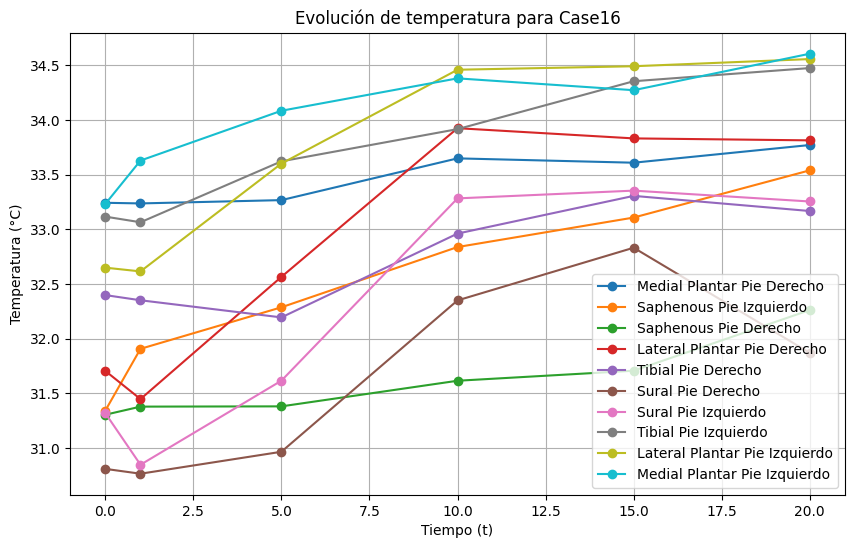

[t0_caso17_jpg.rf.d252de5c8564984473df897834f68196.jpg] Tiempo de registro: 6.9270 s
[t1_caso17_jpg.rf.20f557ea153aedd186edcbacc18b2ad6.jpg] Tiempo de registro: 7.3599 s
[t5_caso17_jpg.rf.5084b1e3cf82cf9d97bb9900627083b9.jpg] Tiempo de registro: 8.3933 s
[t10_caso17_jpg.rf.5debbc69894fcc08156e2bc1cbefe609.jpg] Tiempo de registro: 12.6620 s
[t15_caso17_jpg.rf.ab2154233693e6000d47c07b928c119e.jpg] Tiempo de registro: 4.4620 s
[t20_caso17_jpg.rf.7914d56bdc85a04be123abaa27af6ea0.jpg] Tiempo de registro: 8.7513 s


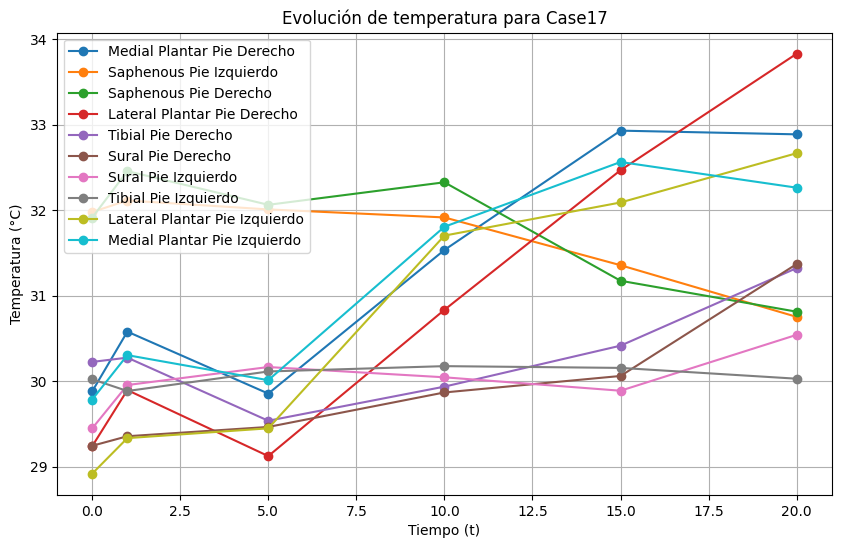

[t0_caso18_jpg.rf.bd161936c2099dc6d35bf095afd2c824.jpg] Tiempo de registro: 4.2981 s
[t1_caso18_jpg.rf.a1104d5a17b291dbacbdc39f7c6bed9c.jpg] Tiempo de registro: 6.3379 s
[t5_caso18_jpg.rf.0f4da2da7614b4f0e27d1fc2f4332456.jpg] Tiempo de registro: 4.6739 s
[t10_caso18_jpg.rf.b9f111400deffcd3a9858d34cc617c14.jpg] Tiempo de registro: 5.8753 s
[t15_caso18_jpg.rf.5a284c2ed9a0e30410351ec2324c9edb.jpg] Tiempo de registro: 2.6078 s
[t20_caso18_jpg.rf.65a6608550222cfa65e757d19343467c.jpg] Tiempo de registro: 3.4483 s
[t25_caso18_jpg.rf.bb67e6afb9d59b39c7572314472eeead.jpg] Tiempo de registro: 5.3288 s


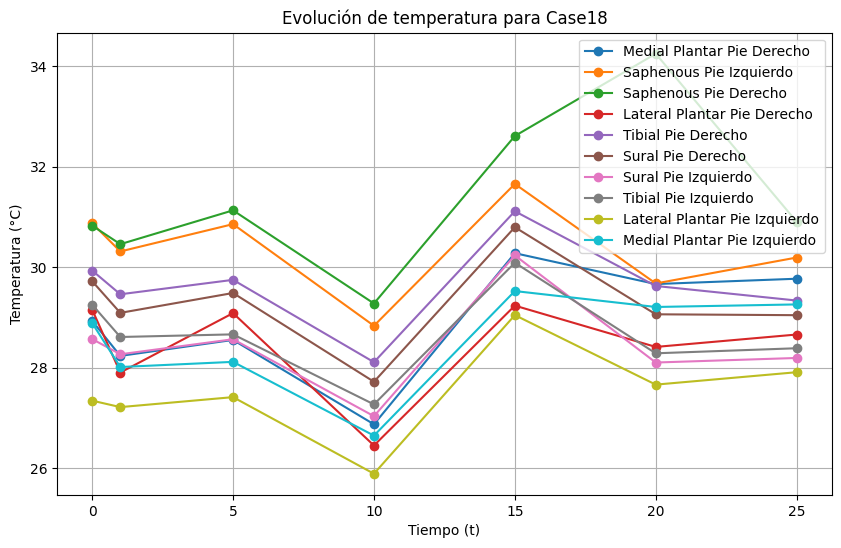

[t0_caso19_jpg.rf.d150eecc65400e954c35a1743b032d06.jpg] Tiempo de registro: 8.1297 s
[t1_caso19_jpg.rf.52f5ff8a4830c1618aa4c6799e0dac06.jpg] Tiempo de registro: 4.9305 s
[t5_caso19_jpg.rf.6167dc114e248e166bc93b124555681c.jpg] Tiempo de registro: 6.8343 s
[t10_caso19_jpg.rf.e394862c9538dac21d2c5b3477e31d39.jpg] Tiempo de registro: 8.3234 s
[t15_caso19_jpg.rf.9e12161078d2fbdea42036558279671c.jpg] Tiempo de registro: 4.8354 s
[t20_caso19_jpg.rf.e220b227b3c5c78003f1bd5d3e873598.jpg] Tiempo de registro: 5.1502 s
[t25_caso19_jpg.rf.25f63ae3f3b4619e66eb79bc6b115c75.jpg] Tiempo de registro: 4.9194 s


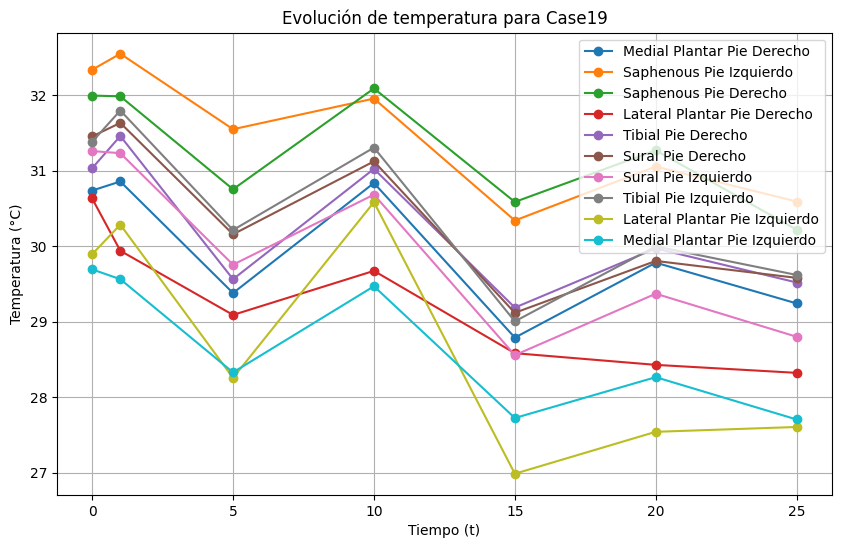

[t0_caso20_jpg.rf.e7edcda62a1b685144ac7488d6a7d653.jpg] Tiempo de registro: 8.3490 s
[t1_caso20_jpg.rf.4a847c9c250eaf2c75dba627710762c5.jpg] Tiempo de registro: 7.6724 s
[t5_caso20_jpg.rf.5eca0bc888470b87b56d5b418818df2f.jpg] Tiempo de registro: 5.7416 s
[t10_caso20_jpg.rf.9f0431942f916aac5a5a7afe46c65f4f.jpg] Tiempo de registro: 7.2686 s
[t15_caso20_jpg.rf.b7560b513101177d8e2b6a8f6ae33087.jpg] Tiempo de registro: 7.6882 s
[t20_caso20_jpg.rf.203941bf6c869b237083d43ecc0d3ee6.jpg] Tiempo de registro: 11.5041 s


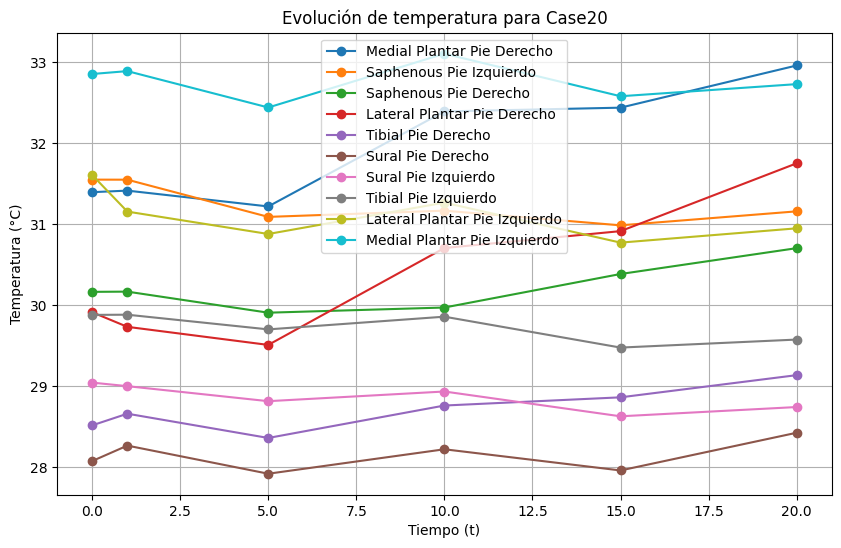

[t0_caso21_jpg.rf.606061176e9e4658b4957ce0d9d5720b.jpg] Tiempo de registro: 4.5993 s
[t1_caso21_jpg.rf.5c2816e452dd45b50d2b5866643bcb87.jpg] Tiempo de registro: 4.4426 s
[t5_caso21_jpg.rf.b8ff08c9480f7ea4dd97ca35d5a08c68.jpg] Tiempo de registro: 6.2364 s
[t10_caso21_jpg.rf.a64b0507008f2fb86f0c97795161c474.jpg] Tiempo de registro: 7.8062 s
[t15_caso21_jpg.rf.a9bbb075db5c299016b7f68b93dec2fd.jpg] Tiempo de registro: 3.4608 s


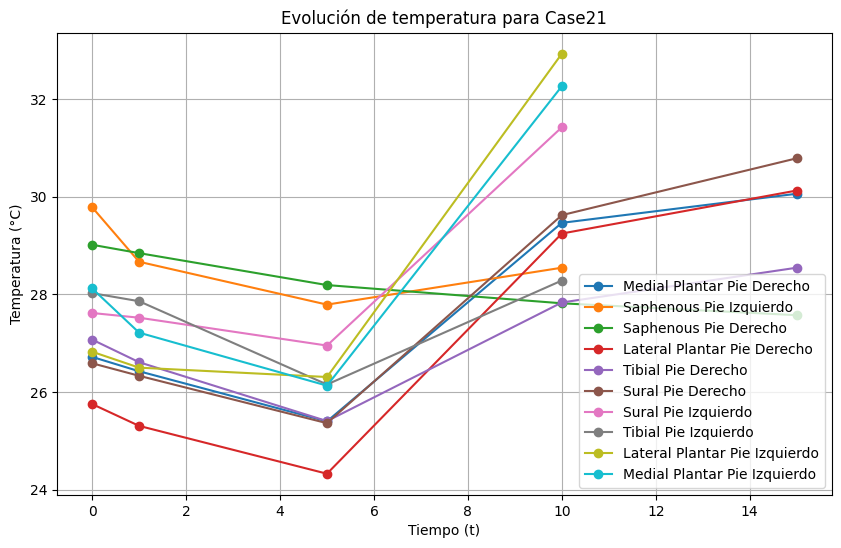

[t0_caso22_jpg.rf.e8aed72a406be37679000cae57cd6ab3.jpg] Tiempo de registro: 5.3632 s
[t1_caso22_jpg.rf.96bc3ae8fdc586a973802a73583b6e67.jpg] Tiempo de registro: 4.8918 s
[t5_caso22_jpg.rf.e5dc702bbd992adcacfce8e2761c9f93.jpg] Tiempo de registro: 6.2711 s
[t10_caso22_jpg.rf.a87533afd4466e83cd1001ac8f0b5ed6.jpg] Tiempo de registro: 7.4787 s
[t15_caso22_jpg.rf.5fb8bfd0b8fb19c11aa78538b0b3ea66.jpg] Tiempo de registro: 5.9928 s
[t20_caso22_jpg.rf.36fd88d5f932b823bf2dfa5a9e3f0e0d.jpg] Tiempo de registro: 3.2128 s


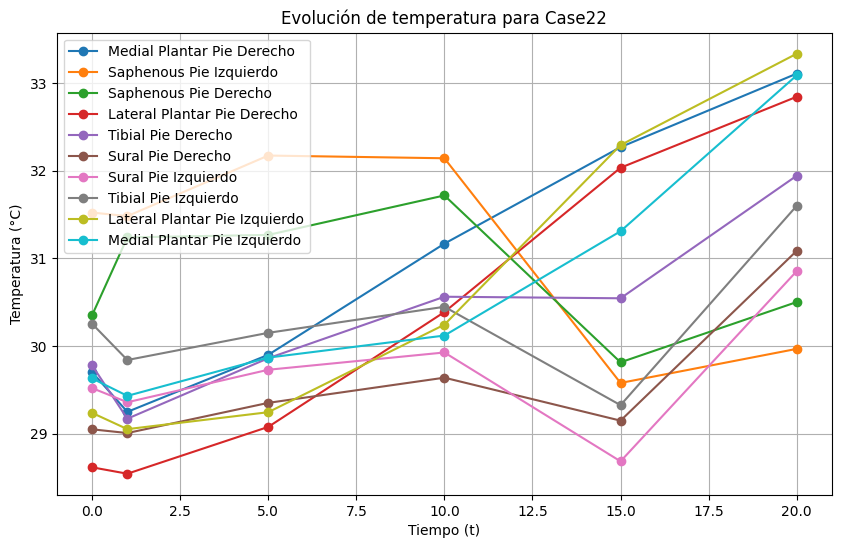

[t0_caso23_jpg.rf.b09f0558455d1a39def077cdf4f2c4e8.jpg] Tiempo de registro: 7.6805 s
[t1_caso23_jpg.rf.9f03409c339c507d82bf5a5aacf7abef.jpg] Tiempo de registro: 3.9323 s
[t5_caso23_jpg.rf.28254f192375d500fd2b4565b843aa03.jpg] Tiempo de registro: 4.8871 s
[t10_caso23_jpg.rf.a0a98c6e48087a78c7a6ad983949f6c9.jpg] Tiempo de registro: 4.3733 s
[t15_caso23_jpg.rf.928a91ffc3b2b6c54244eb7764f7af14.jpg] Tiempo de registro: 4.5716 s
[t20_caso23_jpg.rf.ba797cf123ab9ccf3ac3ebe5d585dfb9.jpg] Tiempo de registro: 5.0760 s


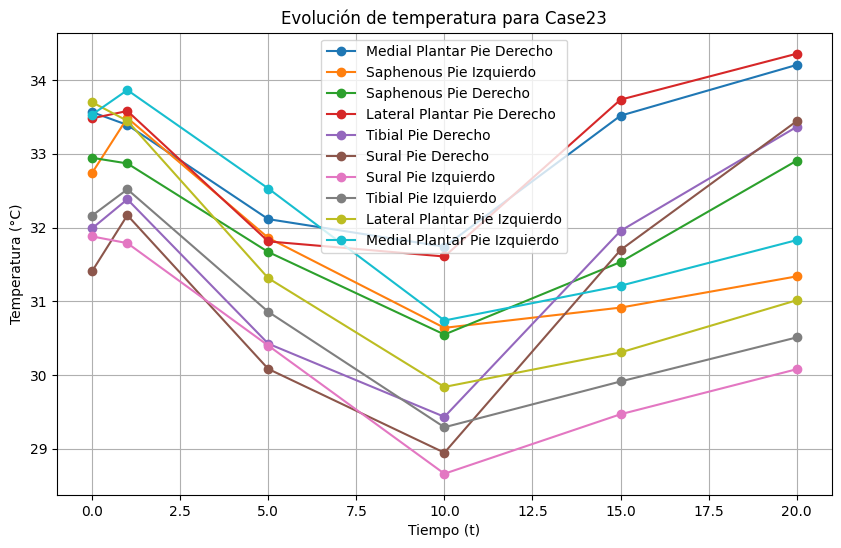

[t0_caso24_jpg.rf.b939ce158697fe2b3f31e3e36c56cbf9.jpg] Tiempo de registro: 11.3426 s
[t1_caso24_jpg.rf.4c0851e7ada5c1e765fcfbd246e935c6.jpg] Tiempo de registro: 14.4057 s
[t5_caso24_jpg.rf.e391c910ccde7493b4e0134d3b074352.jpg] Tiempo de registro: 5.5546 s
[t10_caso24_jpg.rf.65c995fe958aaa1adde7c5a406d67b50.jpg] Tiempo de registro: 15.2546 s
[t15_caso24_jpg.rf.e83644a5ff41a236e99afe3a825a8d18.jpg] Tiempo de registro: 10.5782 s
[t20_caso24_jpg.rf.89938fb7348ffd8ac5fcf973b6f2baa7.jpg] Tiempo de registro: 7.5069 s
[t25_caso24_jpg.rf.f41492e023897afaec16a32a75c58b48.jpg] Tiempo de registro: 3.5116 s


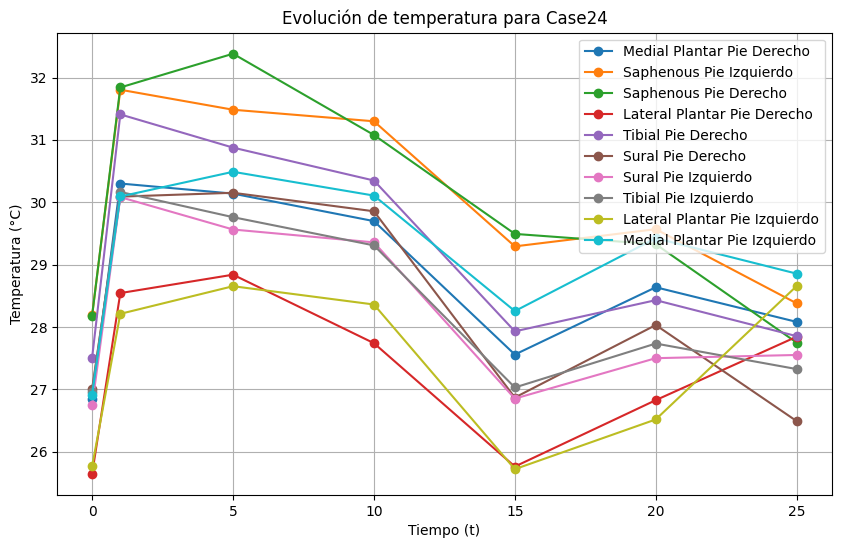

[t0_caso25_jpg.rf.636a38a0e30fa8180a94e1604fd26976.jpg] Tiempo de registro: 2.5539 s
[t1_caso25_jpg.rf.b916a3cfeb5c9b9cf591354ce318a4e7.jpg] Tiempo de registro: 5.3798 s
[t5_caso25_jpg.rf.d7a3fc600ecdacfd2562329684e9b608.jpg] Tiempo de registro: 5.0935 s
[t10_caso25_jpg.rf.ba527efbffbabe87f93d679f01a7f73a.jpg] Tiempo de registro: 4.1000 s
[t15_caso25_jpg.rf.66a7c055b5eb1097a4697c93f9c11770.jpg] Tiempo de registro: 4.2745 s
[t20_caso25_jpg.rf.8cd2cafc442afdfbfe7c3479bae997b8.jpg] Tiempo de registro: 3.7629 s


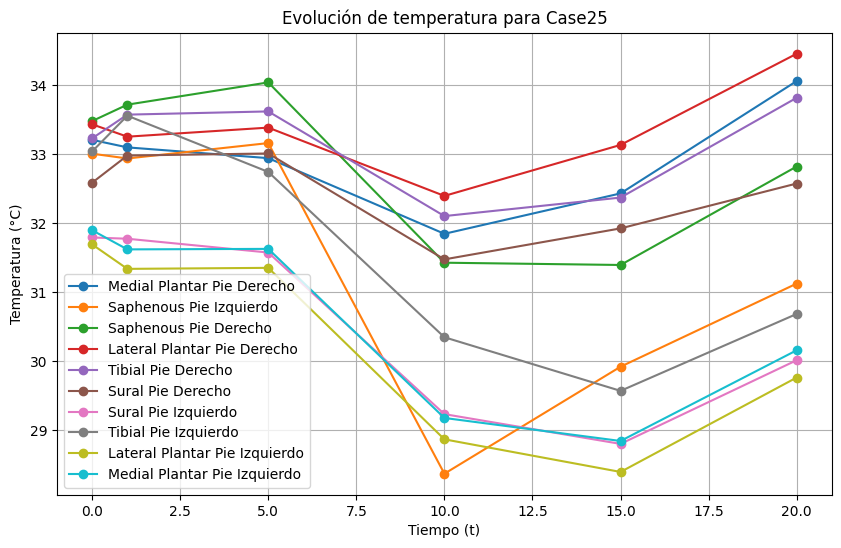

[t0_caso26_jpg.rf.b9fd89ae34d6932ae1739b29fd5ff706.jpg] Tiempo de registro: 2.3938 s
[t1_caso26_jpg.rf.e7094bcc12383f49750818440b2359da.jpg] Tiempo de registro: 3.2892 s
[t5_caso26_jpg.rf.3f50fa35962cc2c50fe33ee352609b1f.jpg] Tiempo de registro: 3.7433 s
[t10_caso26_jpg.rf.a133a2fbecd213b37c088e20e1aa698d.jpg] Tiempo de registro: 3.4513 s
[t15_caso26_jpg.rf.ede359a6191cf6a1e8b8e51c9a5d6e37.jpg] Tiempo de registro: 2.1485 s
[t20_caso26_jpg.rf.473291ddfc2d99c99830b84214754e97.jpg] Tiempo de registro: 3.5027 s


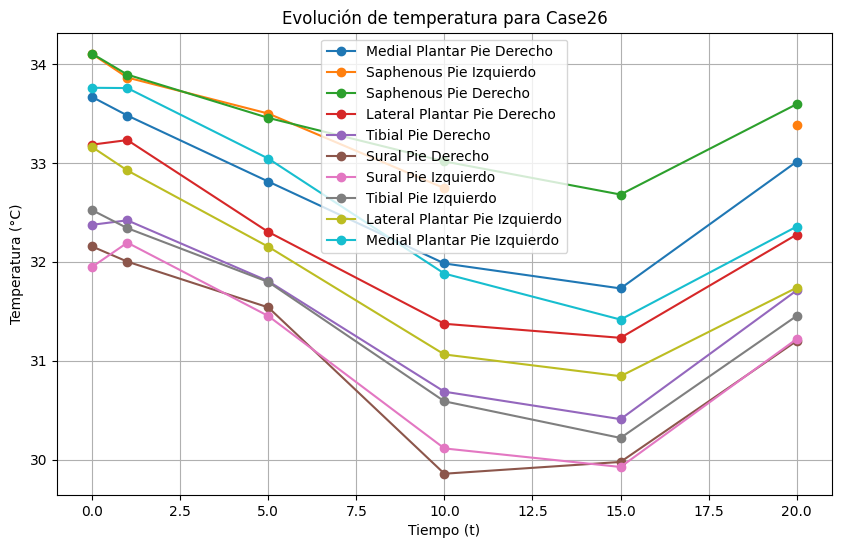

[t0_caso27_jpg.rf.21d2da2b20bc933b2f236400b50edd0b.jpg] Tiempo de registro: 3.0746 s
[t1_caso27_jpg.rf.c91204cfe4efd751dda354ec906038c8.jpg] Tiempo de registro: 2.1225 s
[t5_caso27_jpg.rf.6ff82647ab4ad075ca9de1a7157875fa.jpg] Tiempo de registro: 3.6662 s
[t10_caso27_jpg.rf.812c75f72dd8fcacb785d6dcccd57f2e.jpg] Tiempo de registro: 2.4172 s
[t15_caso27_jpg.rf.059808d8c0538091afca1124295b30a3.jpg] Tiempo de registro: 1.6267 s
[t20_caso27_jpg.rf.d079cabc3b855d33174288cb62abdfa6.jpg] Tiempo de registro: 2.7421 s


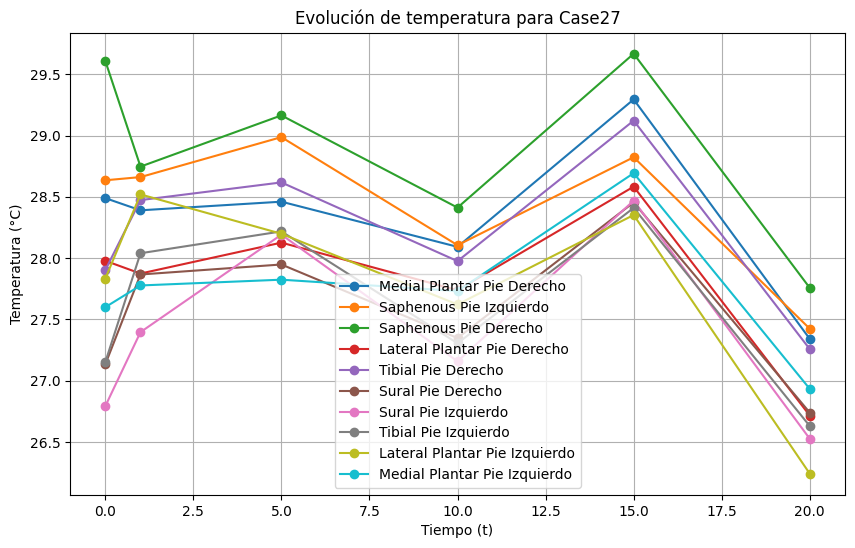

[t0_caso28_jpg.rf.a0e70521293444b1cb5d83a067f06826.jpg] Tiempo de registro: 7.6965 s
[t1_caso28_jpg.rf.c447f3f4068638c27e3c0bcb84dedc84.jpg] Tiempo de registro: 3.8113 s
[t5_caso28_jpg.rf.d0492a74e0a99b4e52b2a272d52c5c64.jpg] Tiempo de registro: 3.5077 s
[t10_caso28_jpg.rf.55eb69b476ee465c4247c8db162e6a47.jpg] Tiempo de registro: 6.0544 s
[t15_caso28_jpg.rf.413faa109fd12a83afdd46814ff9a6bd.jpg] Tiempo de registro: 3.7975 s
[t20_caso28_jpg.rf.aca91345c2ff5aca5963f314639a234b.jpg] Tiempo de registro: 4.8313 s


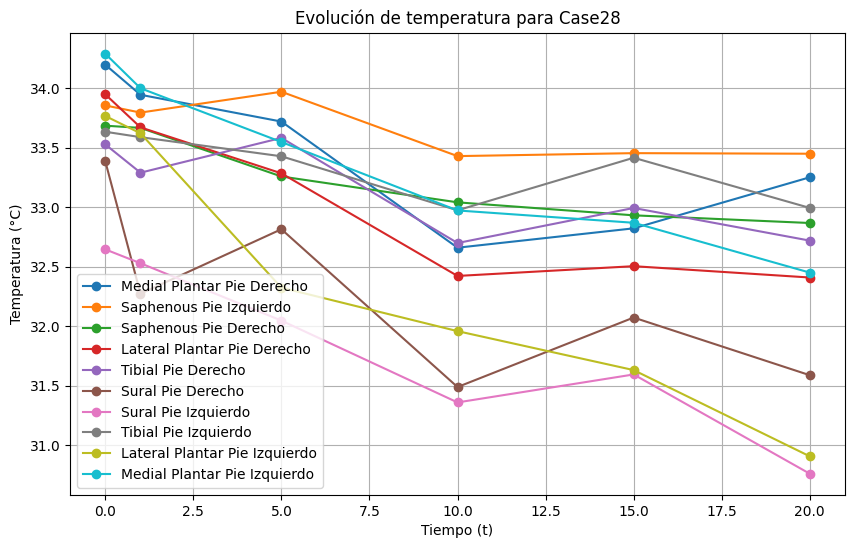

[t0_caso29_jpg.rf.0ab3f1b73977c57951f4c5acd27a5048.jpg] Tiempo de registro: 3.8199 s
[t1_caso29_jpg.rf.bddc8b582f3ed2748620d236e76a9e36.jpg] Tiempo de registro: 3.0813 s
[t5_caso29_jpg.rf.455f0512394673107de0b638411be1d6.jpg] Tiempo de registro: 4.6676 s
[t10_caso29_jpg.rf.0bd28e972b1fa3b8129bac5bd71da3fd.jpg] Tiempo de registro: 4.1500 s
[t15_caso29_jpg.rf.c79663a929be5471d986202f6530e8a1.jpg] Tiempo de registro: 7.1288 s
[t20_caso29_jpg.rf.3d4223561869ff0e6ee9d82cf0b9c9c8.jpg] Tiempo de registro: 2.3985 s


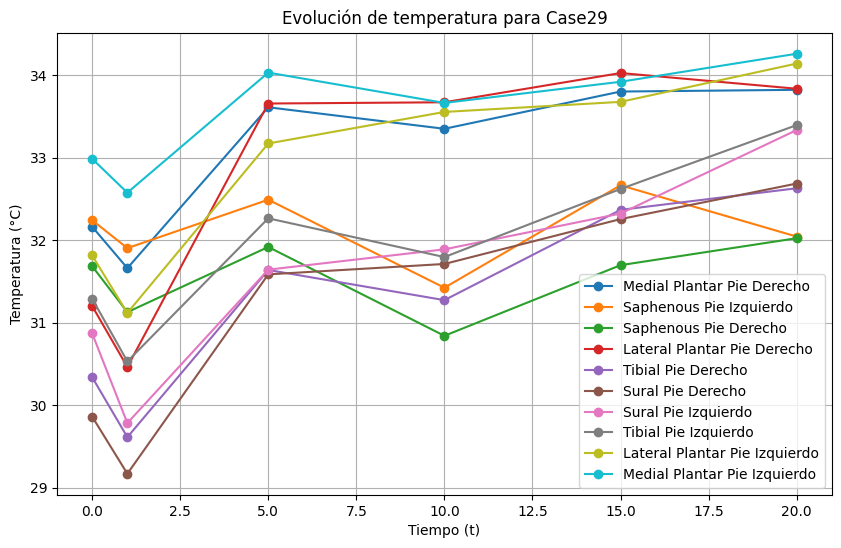

[t0_caso30_jpg.rf.c376181cbb532c70c5badd5c0664eb20.jpg] Tiempo de registro: 4.9951 s
[t1_caso30_jpg.rf.19cd8a931d28837a8ab05a3475ec1ac0.jpg] Tiempo de registro: 2.4166 s
[t5_caso30_jpg.rf.215a982708754c335c13ef670eb758f1.jpg] Tiempo de registro: 3.3231 s
[t10_caso30_jpg.rf.9234aa6dcf579a9e4424799f8e5ab3d3.jpg] Tiempo de registro: 3.3975 s
[t15_caso30_jpg.rf.aa935f7fe0d17e7837bf89255e8fee00.jpg] Tiempo de registro: 2.7099 s
[t20_caso30_jpg.rf.5543b314884d978c828df52ae69ad028.jpg] Tiempo de registro: 1.9863 s


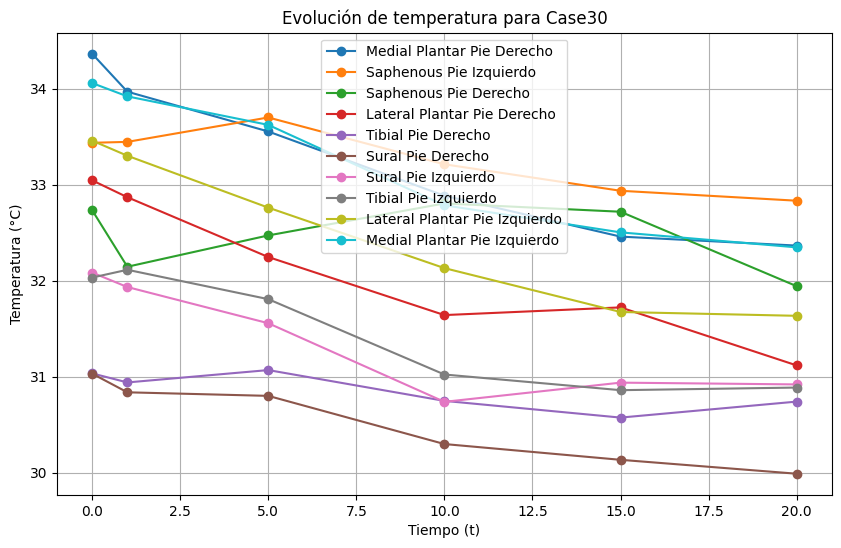

In [ ]:
# Recorremos las carpetas en orden numérico
for case in sorted(os.listdir(cases_dir), key=lambda x: int(re.search(r'\d+', x).group())):
    case_path = os.path.join(cases_dir, case)
    if not os.path.isdir(case_path):
        continue

    # Listamos las imágenes y extraemos (tiempo, path)
    image_list = []
    for file in os.listdir(case_path):
        if file.lower().endswith((".jpg", ".jpeg", ".png")):
            t_val, _ = extract_time_case(file)
            if t_val is not None:
                image_list.append((t_val, os.path.join(case_path, file)))
    if len(image_list) == 0:
        continue
    # Ordenamos las imágenes por tiempo (ascendente)
    image_list.sort(key=lambda x: x[0])

    times = []
    results_list = []  # Lista de diccionarios con temp_results de cada imagen
    union_areas = set()  # Todas las áreas encontradas en este caso

    for t_val, img_path in image_list:
        result = process_with_registration(img_path)
        if result is None:
            continue
        times.append(t_val)
        temp_results = result["temp_results"]
        results_list.append(temp_results)
        union_areas.update(temp_results.keys())

    # Para cada dermatoma en la unión, construimos la curva
    curves = {area: [] for area in union_areas}
    for temp_results in results_list:
        for area in union_areas:
            # Si el dermatoma no se midió en esta imagen, se asigna np.nan
            curves[area].append(temp_results.get(area, np.nan))

    # Graficamos
    plt.figure(figsize=(10,6))
    for area, temps in curves.items():
        plt.plot(times, temps, marker='o', label=area)
    plt.xlabel("Tiempo (t)")
    plt.ylabel("Temperatura (°C)")
    plt.title(f"Evolución de temperatura para {case}")
    plt.legend()
    plt.grid(True)
    plt.show()
